<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transfer_learning/TVshow_characters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons characters classification

## Install libs

In [2]:
!pip install kaggle

## imports

In [40]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn


from matplotlib.font_manager import FontProperties
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook

### Create folder and download the dataset

If you want to follow this track, don't forget to put **your** kaggle API (download kaggle.json from kaggle.com) in the current dirrectory (I assume its 'content' for you)

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c journey-springfield
!unzip -q journey-springfield.zip

 99% 517M/521M [00:15<00:00, 42.9MB/s]
100% 521M/521M [00:15<00:00, 34.9MB/s]


If you cannot perform the actions above or you don't have kaggle account (what are you doing here then?) - uncomment and use the code below. Of course you need to mound the drive and upload your version of dataset

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

### Sort data in order and get labels

In [10]:
path_train = Path('./train/')
path_test = Path('./testset/')

train_val_files = sorted(list(path_train.rglob('*.jpg')))
test_files = sorted(list(path_test.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

### Check characters distribution in train dataset

In [11]:
def plot_character_distribution(train_labels):
    plt.figure(figsize=(12,6))
    counts = pd.Series(train_labels).value_counts()
    sns.barplot(x=counts.sort_values(ascending=False), y=counts.keys())
    plt.tight_layout()
    plt.show()
    return counts

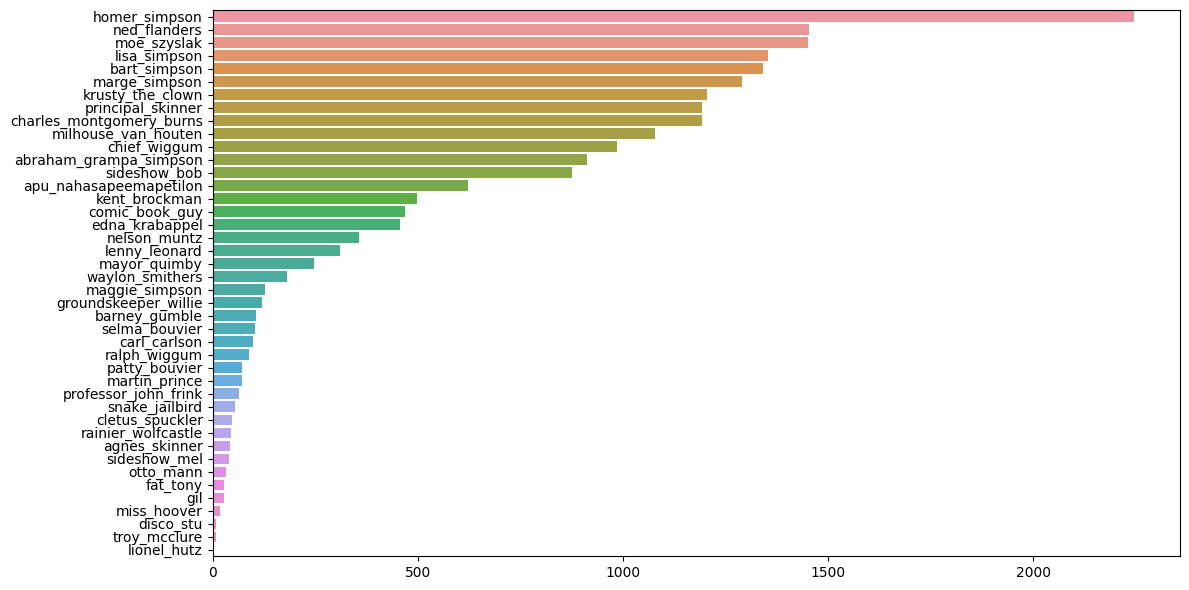

In [12]:
charnums = plot_character_distribution(train_val_labels)

### Split train labels into train and val data with stratification

In [13]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

## Load images as Datasets

In [14]:
class CFG:
  rescale_image = 224
  imagenet_means = [0.485, 0.456, 0.406]
  imagenet_stds = [0.229, 0.224, 0.225]
  batchsize = 64
  lr = 4e-3
  device = lambda: 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = np.array(CFG.imagenet_stds) * inp.numpy().transpose(
                                      (1, 2, 0)) + np.array(CFG.imagenet_means)
    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [16]:
class CustomDataset(Dataset):
  def __init__(self, files, train=True):
    super().__init__()
    self.files = sorted(files)
    self.le = LabelEncoder()
    self.train_mode = train
    if train:
      self.labels = self.l_encode

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    img = self._load_sample(filename)
    img = self._get_augs(img) if self.train_mode else self._get_transforms(img)
    return self._get_xy(img, idx)


  @staticmethod
  def _load_sample(name):
    img = Image.open(name)
    img.load()
    img = img.resize((CFG.rescale_image, CFG.rescale_image))
    return img

  @property
  def l_encode(self):
    labels = [path.parent.name for path in self.files]
    self.le.fit(labels)
    with open('le.pkl', 'wb') as f:
      pickle.dump(self.le, f)
    return labels


  def _get_xy(self, x, y_idx):
    if self.train_mode:
      label = self.labels[y_idx]
      label_id = self.le.transform([label])
      return x, label_id.item()
    else:
      return x


  @staticmethod
  def _get_augs(img):
    percentile = CFG.rescale_image//10
    transform = transforms.Compose([transforms.CenterCrop(size=CFG.rescale_image),
                                    transforms.RandomPerspective(),
                                    transforms.RandomCrop(CFG.rescale_image - percentile),
                                    transforms.RandomResizedCrop(CFG.rescale_image),
                                    transforms.RandomRotation(degrees=(
                                                      -percentile, percentile)),
                                    transforms.RandomHorizontalFlip(p=0.9),
                                    transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image)),
                                    transforms.Lambda(lambda x: np.array(
                                                    x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)



  @staticmethod
  def _get_transform(img):
    transform = transforms.Compose([transforms.Resize(size=(CFG.rescale_image,
                                                            CFG.rescale_image)),
                                    transforms.Lambda(lambda x: np.array(
                                                      x, dtype='float32') / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize(CFG.imagenet_means,
                                                         CFG.imagenet_stds)])
    return transform(img)



### Set two kinds of data - for train: train and val and for test: trainval and test

In [17]:
train_dataset = CustomDataset(train_files)
val_dataset = CustomDataset(val_files)

trainval_dataset = CustomDataset(train_val_files)
test_dataset = CustomDataset(test_files, False)

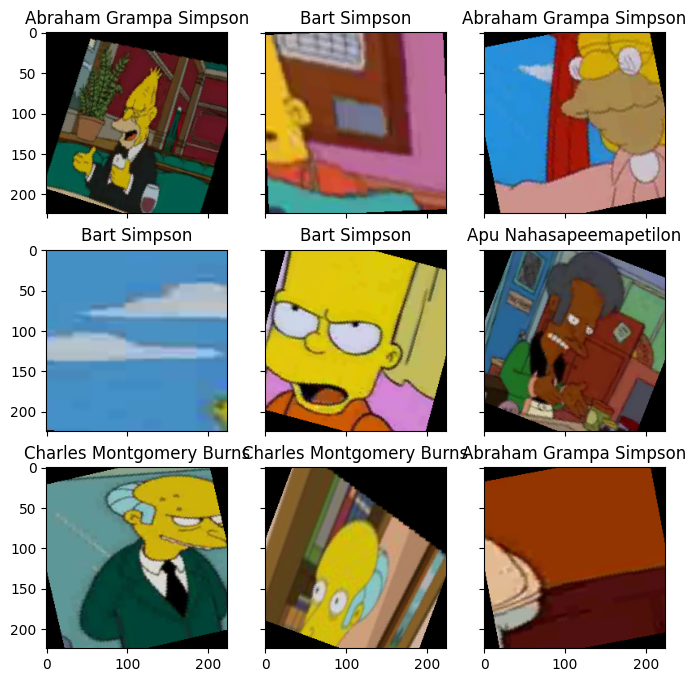

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Using random weighted sampler

kudos to [wervlad](https://www.kaggle.com/code/wervlad/baseline-2fc-augmentations) [vladislavzenin](https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler) and [ndyarrrr](https://www.kaggle.com/code/ndyarrrr/1-0-score-with-baseline-model-3fc) for the WightedSampler

#### vladislavzenin and wervlad's approach

In [19]:
weights_count = {k: 1/v for k,v in charnums.items()}
weights_samples = [weights_count[label] for label in train_val_labels]
N_vw = charnums.max() * len(weights_count)

train_sampler_1 = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)
train_loader_1 = DataLoader(trainval_dataset, batch_size=CFG.batchsize, sampler=train_sampler_1, num_workers=2)

#### ndyarrrr's approach

In [20]:
count_weights = {key: 1/value for key, value in charnums.items()}
sample_weights = len(train_val_files) * [0]

for i, (data, label) in enumerate(tqdm(trainval_dataset)):
    label_weight = count_weights[trainval_dataset.le.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

100%|██████████| 20933/20933 [04:24<00:00, 79.15it/s]


In [24]:
N_n = charnums.max() * len(count_weights)
print(N_n)
train_sampler_2 = WeightedRandomSampler(sample_weights, num_samples=int(N_n), replacement=True)
train_dataloader_2 = DataLoader(trainval_dataset, batch_size=CFG.batchsize*2, sampler=train_sampler_2) #one worker twice tha batchsize

94332


#### compare dicts in two approaches

In [22]:
weights_count == count_weights

True

We are going to utilize all of this in the final part of learning when we train on train+val dataset but lets have a useful func instead of creating one instance in a cell

In [37]:
def weighted_dataloader_1(datasetfiles):
  labels = [path.parent.name for path in datasetfiles]
  counts = pd.Series(labels).value_counts()
  weights_count = {key: 1/val for key, val in counts.items()}
  weights_samples = [weights_count[label] for label in labels]
  N_vw = counts.max() * len(weights_count)
  train_sampler = WeightedRandomSampler(weights_samples, num_samples=int(N_vw), replacement=True)

  dataset = CustomDataset(datasetfiles)
  train_loader = DataLoader(dataset, batch_size=CFG.batchsize, sampler=train_sampler, num_workers=2)
  return dataset

In [35]:
def weighted_dataloader_2(datasetfiles):
  labels = [path.parent.name for path in datasetfiles]
  counts = pd.Series(labels).value_counts()
  count_weights = {key: 1/value for key, value in counts.items()}
  sample_weights = len(datasetfiles) * [0]

  dataset = CustomDataset(datasetfiles)

  for i, (data, label) in enumerate(tqdm(dataset)):
      label_weight = count_weights[dataset.le.inverse_transform([label])[0]]
      sample_weights[i] = label_weight

  N_n = counts.max() * len(count_weights)
  train_sampler = WeightedRandomSampler(sample_weights, num_samples=int(N_n),
                                        replacement=True)

  train_dataloader = DataLoader(dataset, batch_size=CFG.batchsize,
                                sampler=train_sampler, num_workers=2)
  return dataset

In [39]:
train_ds = weighted_dataloader_1(train_files)
val_ds = weighted_dataloader_1(val_files)

## Write a simple CNN model

In [42]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        #TODO: Dropouts, batchnorm and skip-connections
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(96 * 5 * 5, 2000)
        self.fc2 = nn.Linear(2000, 4000)
        self.fc3 = nn.Linear(4000, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)
        relu = nn.ReLU()
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)

        return x

### Fit epoch function

In [47]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    print(CFG.device())
    for inputs, labels in train_loader:

        inputs = inputs.to(CFG.device())
        labels = labels.to(CFG.device())
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        print('batch loss:', running_loss/processed_data, \
              'acc:', running_corrects.cpu.numpy()/processed_data)


    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

### Eval epoch func

In [48]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(CFG.device())
        labels = labels.to(CFG.device())

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

### Whole training cycle

In [38]:
def train(train_files, val_files, model, epochs, batch_size):
    # we augment train dataset. ti will take longer to learn
    train_loader = weighted_dataloader_1(train_files)
    # we dont do weighted on val
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        # TODO: need scheduler

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss:", train_loss, 'acc:', train_acc)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

### predict func

In [34]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(CFG.device())
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Training process

### Create model instance

In [40]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(CFG.device())
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2400, out_fea

### Train

In [41]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

cuda
3.7379229068756104
3.7469338178634644
3.7462941805521646
3.744879901409149
3.745423698425293
3.745140314102173
3.743586438042777
3.743377774953842
3.7436602115631104
3.743237543106079
3.7430042787031694
3.7423028548558555
3.7419260098383975
3.74135114465441
3.7411454995473226
3.7410717010498047
3.7408502522636864
3.7404768731858997
3.740295071350901
3.739736258983612
3.7400497595469155
3.740174109285528
3.7388383201930835
3.7390497028827667
3.739069757461548
3.738724717727074
3.7389167503074363
3.738792819636209
3.7388150938625992
3.7386558691660565
3.7389634424640286
3.7387099638581276
3.7383808583924263
3.7382393514408783
3.7385378633226667
3.738313462999132
3.7377470763953955
3.737355903575295
3.7365440283066187
3.7361033499240874
3.735729008186154
3.7351469028563726
3.7339359106019487
3.7326719652522695
3.732027260462443
3.7310298940409785
3.7298389597141997
3.7292313476403556
3.7292199426767776
3.728622317314148
3.7276504554000556
3.726401347380418
3.7249420723825133
3.725075

epoch:  50%|█████     | 1/2 [14:00<14:00, 840.93s/it]


Epoch 001 train_loss: 2.7199     val_loss 2.1674 train_acc 0.2801 val_acc 0.3966
cuda
1.7092963457107544
1.794924795627594
1.7583747307459514
1.7358260452747345
1.7911143064498902
1.8264663020769756
1.8382224866322108
1.8385076373815536
1.8421057330237494
1.81918603181839
1.8005572449077258
1.8011356095472972
1.7909775513869066
1.7656936986105782
1.7751169602076213
1.7714577540755272
1.779014601426966
1.7677509784698486
1.7671126817402087
1.771652340888977
1.7622069404238747
1.750557780265808
1.7464026938314023
1.7473775446414948
1.7501965475082397
1.7413819569807787
1.7442392861401592
1.7321415884154183
1.7374202465188915
1.7350567022959391
1.7271231989706717
1.7266562469303608
1.730507644740018
1.7290887657333822
1.7256892715181624
1.7218909627861447
1.7200202458613627
1.7218162386040938
1.7194284139535365
1.7212014585733413
1.7176675505754424
1.7164689501126607
1.7145291677741117
1.7103224369612606
1.7097934087117512
1.706958065862241
1.7109358513608892
1.7095222001274426
1.7140098

epoch: 100%|██████████| 2/2 [27:40<00:00, 830.47s/it]


Epoch 002 train_loss: 1.4342     val_loss 1.7226 train_acc 0.6169 val_acc 0.5229


### visualize learning emmm curve

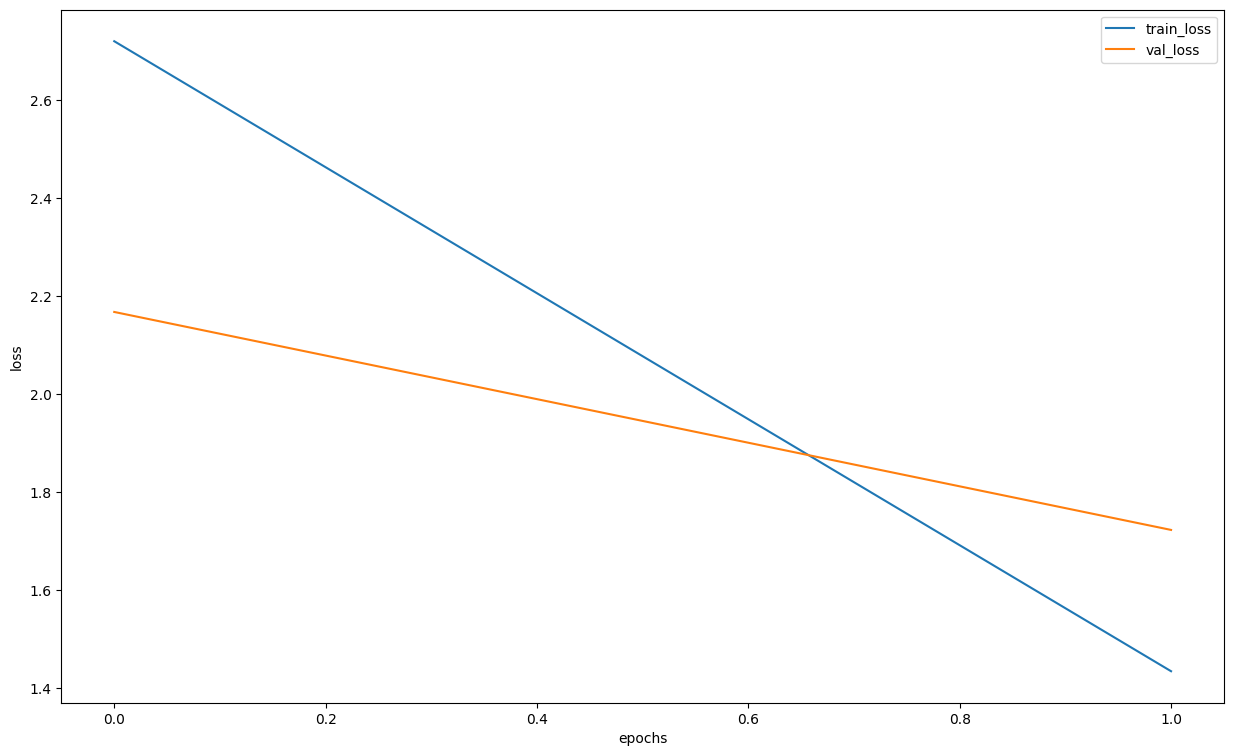

In [51]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Predict a sample

In [52]:
def predict_one_sample(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(CFG.device())
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

### prodice and calculate f1-score

In [53]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)
label_encoder = pickle.load(open("le.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)


F1-оценка: 0.20000000000000004


it sucks after 2 epochs since augmentations take longer to learn

### visualize confidence of the CCN. it sucks

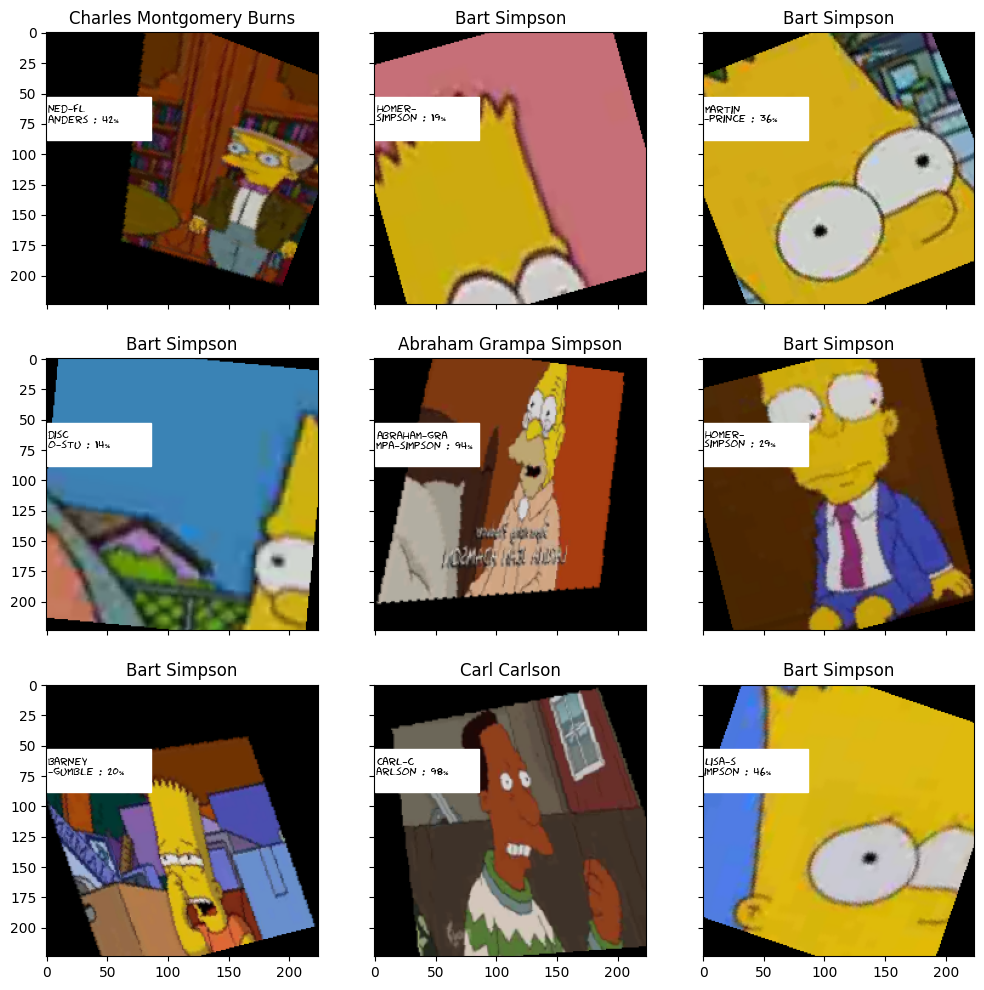

In [55]:

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')